[  26.97329301 1683.90610471    9.656356  ] 23.20731791603732


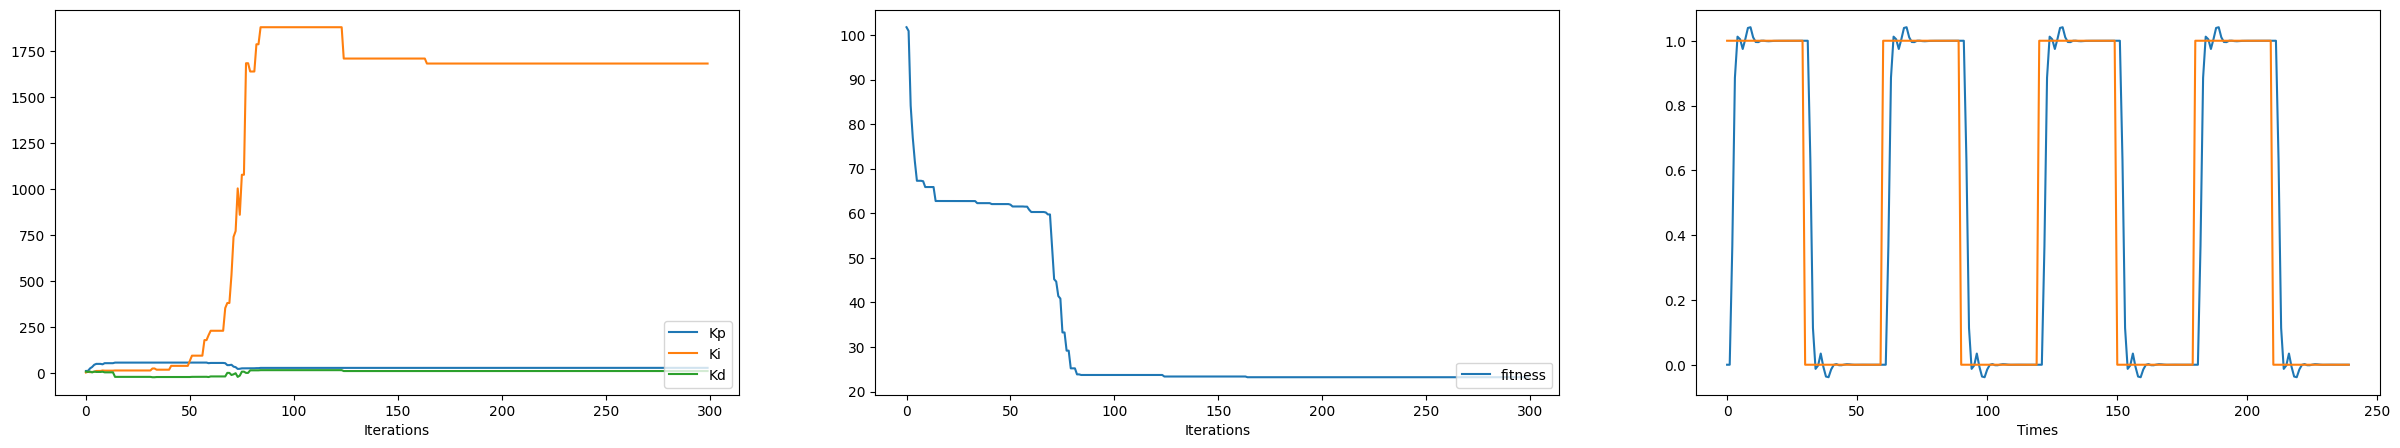

In [7]:
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

from prometheus_client import Counter
# import scipy.signal as signal


num_particles = 50
num_iterations = 300
pop_size = 10
num_dims = 3
weight = 2

c1 = 1.0
c2 = 1.0
c3 = 0.0
gbestx = []
gbesty = +np.inf
lbestx = []
# gbesty_period_temp = []
gbesty_period = [0]*60



total_error = [0]*num_particles
prev_error = [0]*num_particles

ling = 0.5
DT = 0.01
TARGET = [0]*240
state=[0,0,0]   #y(k+1),y(k),y(k-1)
u=[0,0,0]   #u(k+1),u(k),u(k-1)

Kp_plots = []
Ki_plots = []
Kd_plots = []
y_plots = []

#error=1
for i in range(8):
    if (i%2) == 0:
        num = 1
    else:
        num = 0
    for j in range(30):
        TARGET[30*i+j] = num



class Particle():
    def __init__(self,objective):
        global num_dims
        self.x = np.random.random([num_dims])*10
        self.y = np.inf
        self.v = np.random.uniform(-1,1,[num_dims])
        self.pbesty = self.y
        self.pbestx = copy.deepcopy(self.x)

    def update_velocity(self,weight,gbestx,lbestx=np.zeros(num_dims)):
        global c1,c2,c3,bounds,num_dims
        rand1 = np.random.random(num_dims)
        rand2 = np.random.random(num_dims)
        rand3 = np.random.random(num_dims)
        new_velocity = np.zeros(num_dims)
        for i in range(num_dims):
            new_velocity[i] = weight*random.random()*self.v[i] + c1*rand1[i]*(self.pbestx[i] - self.x[i]) + c2*rand2[i]*(gbestx[i] - self.x[i])+c3*rand3[i]*(lbestx[i]-self.x[i])
            self.v[i] = new_velocity[i]	               #Update velocity
            self.x[i] +=self.v[i]                      #Update position
            #self.x[i] = np.clip(self.x[i],*bounds[i])  #Clip state variables to bounds


def PSO(objective):
    global gbestx,gbesty,num_iterations,num_particles,num_dims,pop_size,weight
    particles=[]
    count=1

    # 初始化
    for i in range(num_particles):
        p = Particle(objective)
        particles.append(p)
        if p.y < gbesty:
            gbesty = p.y
            gbestx = copy.deepcopy(p.x)

    # 迭代
    for i in range(num_iterations):
        output = []
        for p in range(num_particles):
            count = count%pop_size
            particles[p].y = objective(particles[p].x,p)
            output.append(particles[p].y)
            if output[p] < particles[p].pbesty:
                particles[p].pbesty = output[p]
                particles[p].pbestx = copy.deepcopy(particles[p].x)
            if output[p] < gbesty or len(gbestx) == 0:              #Update Global best
                gbesty = output[p]
                gbestx = copy.deepcopy(particles[p].x)

            if count == 0:
                lbest = max(particles[p-pop_size+1:p+1], key = lambda p:p.y)
                lbestx = lbest.x
                for j in range(p-pop_size+1,p+1):
                    particles[j].update_velocity(weight,gbestx = gbestx,lbestx = lbestx)
                lbest = []
                lbestx=[]
            count+=1
        Kp_plots.append(gbestx[0])
        Ki_plots.append(gbestx[1])
        Kd_plots.append(gbestx[2])
        y_plots.append(gbesty)

    return gbestx

#output(y(k))
def fitfunction(u):
    return 2.6*state[1]-1.2*state[2]+u[1]+1.2*u[2]+ling*state[1]*math.sin(u[1]+u[2]+state[1]+state[2])

#算fitness
def ObjectiveFunction(X,p):
    global total_error,prev_error,gbesty_period,gbesty,state,u
    gbesty_period_temp =[]
    Kp=X[0]
    Ki=X[1]
    Kd=X[2]

    cost = 0
    state=[0,0,0]
    u=[0,0,0]

    for i in range(240):
        gbesty_period_temp.append(state[1])
        error = TARGET[i]-state[1]
        cost += abs(error)

        P = Kp * error
        I = Ki * total_error[p]
        D = Kd * (error-prev_error[p])
        u[0] = P + I + D
        if u[0]>=50:
            u[0]=50
        elif u[0]<=-50:
            u[0]=-50

        prev_error[p] = error
        total_error[p] = total_error[p] + error*DT

        state[0] = fitfunction(u)*DT
        u[2]=u[1]
        u[1]=u[0]
        state[2] = state[1]
        state[1] = state[0]

    if cost < gbesty:
        gbesty_period = gbesty_period_temp
    return cost

PSO(ObjectiveFunction)

fig = plt.figure(figsize=(30,5))

plt.subplot(1, 3, 1)
x = np.arange(0,len(Kp_plots),1)
plt.plot(x,Kp_plots,label = "Kp")
plt.plot(x,Ki_plots,label = "Ki")
plt.plot(x,Kd_plots,label = "Kd")
plt.legend(loc='lower right')
plt.xlabel("Iterations")

plt.subplot(1, 3, 2)
plt.plot(x,y_plots,label = "fitness")
plt.legend(loc='lower right')
plt.xlabel("Iterations")

print(gbestx,gbesty) #最佳解PID參數,最佳解的fitness(total_error)
plt.subplot(1, 3, 3)
x = np.arange(0,240,1)
y = gbesty_period
plt.plot(x,y,label = "wave")
plt.plot(x,TARGET,label = "TARGET")
plt.xlabel("Times")
plt.show()

In [8]:
import numpy as np

y = np.array(y)
TARGET = np.array(TARGET)

mae = sum(abs(y - TARGET))/240
print(f"{mae:.10f}")

0.0966971580
